## Mushroom predictor

In the context of this project, our primary objective is to leverage a dataset encompassing various mushroom characteristics. Through advanced data science methodologies, we aim to develop a predictive model capable of discerning whether a given mushroom is likely to be poisonous or not. 

This project was inspired by the article https://towardsdatascience.com/shap-for-categorical-features-7c63e6a554ea

We start by importing the necessary data.

In [1]:
#importing data from uciml repo
from ucimlrepo import fetch_ucirepo 
import pandas as pd
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
# metadata 
print(mushroom.metadata) 
# variable information 
print(mushroom.variables) 

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

Providing context for those less familiar with mushrooms, the structure of these fungi is intricately divided into distinct parts, as illustrated in the figure below:

<img src="anatomy.jpg" alt="anatomy" style="width:40%; height:40%;" >

Understanding these structural components is crucial, as they play a fundamental role in evaluating the potential toxicity of a mushroom. Now, as we proceed with our analysis, the initial step involves segregating the features from the target variable, laying the groundwork for a comprehensive exploration of the dataset.


In [2]:
X = mushroom.data.features 
y = mushroom.data.targets 
data = pd.concat([X,y],axis=1)
display(data)

#save data (as pandas dataframes)
data.to_csv('mushroom.csv', index = False)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,o,o,p,o,o,p,b,c,l,e
8120,x,s,n,f,n,a,c,b,y,e,...,o,o,p,n,o,p,b,v,l,e
8121,f,s,n,f,n,a,c,b,n,e,...,o,o,p,o,o,p,b,c,l,e
8122,k,y,n,f,y,f,c,n,b,t,...,w,w,p,w,o,e,w,v,l,p


In [3]:
#imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shap
shap.initjs()
from shap import TreeExplainer, Explanation

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

import warnings

The data imported is a dataframe where every variable is a categorical type. When working with categorical data in machine learning, it is essential to convert these variables into a numerical format that algorithms can understand. Two commonly used techniques for encoding categorical variables are one-hot and label encoding.

We apply One-Hot Encoding when:

1. The categorical feature is not ordinal
2. The number of categorical features is less so one-hot encoding can be effectively applied

We apply Label Encoding when:

1. The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
2. The number of categories is quite large as one-hot encoding can lead to high memory consumption

In this case, let's transform these categorical variables using the One-Hot Encoder

In [4]:
#original feature data
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [5]:
#fit encoder
encoder = OneHotEncoder()
encoder.fit(X)

#transform categorical features
X_encoded = encoder.transform(X).toarray()

#create feature matrix
Xcolumns = X.columns
new_columns = encoder.get_feature_names_out(Xcolumns)

X_encoded = pd.DataFrame(X_encoded, columns= new_columns)

display(X_encoded.head())


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Take note that the 'cap-shape' feature, originally containing 6 distinct values in the original DataFrame, has been transformed by the encoder. Now, we observe 6 separate columns, each representing a binary classification corresponding to the unique values found in the original feature. This was made for every categorical column.

Now we have to transform the class column (poisonous) in binary values. p --> 1, e --> 0

In [6]:
# Convert class to binary classification
class_mapping = {'e': 0, 'p': 1}
warnings.filterwarnings("ignore")
y['poisonous'] = y['poisonous'].map(class_mapping)
y = np.ravel(y)

With the encoded feature table (X_encoded) and the class vector (y) in hand, we can now split the data into training and testing sets. Subsequently, we will employ the Random Forest algorithm to make predictions on the output.

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.5, random_state=0)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=0, 
                               n_estimators=100, 
                               max_depth=3, 
                               min_samples_split=5,
                               min_samples_leaf=3,
                               max_features=5,
                               )
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

Now, to assess the quality of the model's predictions, we commonly employ a classification report.

This report provides a detailed breakdown of the model's performance, allowing the calculation of crucial metrics such as accuracy, precision, recall, and F1-score.

- Accuracy: This metric represents the ratio of correctly predicted observations to the total observations, offering an overall measure of model performance.

- Precision: Defined as the ratio of correctly predicted positive observations to the total predicted positives, precision measures the accuracy of positive predictions.

- Recall (Sensitivity or True Positive Rate): It represents the ratio of correctly predicted positive observations to all actual positives, indicating the model's ability to capture all positive instances.

- F1-score: This metric is the harmonic mean of precision and recall, providing a balanced measure that accounts for both false positives and false negatives.

- Support: The support metric indicates the number of actual occurrences of a class in the specified dataset.


In [8]:
# Generate a classification report
classes = ["edible", "poisonous"]
report = classification_report(y_test, y_pred, target_names=classes)
print(report)


              precision    recall  f1-score   support

      edible       0.97      1.00      0.98      2110
   poisonous       1.00      0.97      0.98      1952

    accuracy                           0.98      4062
   macro avg       0.99      0.98      0.98      4062
weighted avg       0.98      0.98      0.98      4062



Examining the classification report reveals a noteworthy accuracy of 98%, signifying the model's adeptness in predicting outputs based on the provided features.

To further unravel the intricacies of the model's decision-making process in determining the edibility of mushrooms, we turn to visual aids such as permutance importances, SHAP values, and partial dependence plots. These tools offer insights into the factors influencing the model's predictions and enhance our understanding of the intricate relationships between features and outcomes.

Let's start with the permutation importances:

In [9]:
perm = PermutationImportance(model, n_iter=1, random_state=0).fit(X_encoded,y)
weights_html = eli5.show_weights(perm, feature_names = X_encoded.columns.tolist())
weights_html

Weight,Feature
0.0511 ± 0.0000,odor_n
0.0353 ± 0.0000,gill-size_b
0.0290 ± 0.0000,gill-size_n
0.0234 ± 0.0000,spore-print-color_h
0.0212 ± 0.0000,odor_f
0.0116 ± 0.0000,odor_p
0.0047 ± 0.0000,cap-surface_s
0.0041 ± 0.0000,cap-surface_f
0.0037 ± 0.0000,stalk-color-above-ring_g
0.0034 ± 0.0000,gill-color_b


The importance values are currently stored in an HTML-formatted weights object. Our next step involves transforming this data into a pandas DataFrame for more accessible and structured analysis.

In [10]:
weights_df = pd.DataFrame(eli5.explain_weights_df(perm, feature_names = X_encoded.columns.tolist()))
display(weights_df)

,feature,weight,std
0,odor_n,0.051083,0.0
1,gill-size_b,0.035327,0.0
2,gill-size_n,0.029050,0.0
3,spore-print-color_h,0.023387,0.0
4,odor_f,0.021172,0.0
...,...,...,...
112,gill-color_w,-0.001477,0.0
113,stalk-surface-above-ring_k,-0.001723,0.0
114,stalk-color-below-ring_w,-0.001846,0.0
115,bruises_f,-0.001969,0.0


Due to the One-Hot Encoding process, our dataset has expanded to include 117 distinct features, each contributing to the determination of importances.

To streamline our analysis, we will group these importances and aggregate the values by summing them. This consolidation will provide a clearer overview of the collective impact of different features on the model.

In [11]:
# Creating a new Dataframe to store the summed importances
summed_importances = pd.DataFrame(columns=['feature','summed_importance'])

for feat in X.columns.values:
    common_feature = X_encoded.filter(regex=feat, axis=1) # filter features by the common name
    encoded_variables = common_feature.columns.values # get the encoded variables
    select_rows = weights_df[weights_df.isin(encoded_variables).any(axis=1)] # select rows that contain the encoded variables
    sum_feature = select_rows.sum(axis=0)[1] # sum the weights
    warnings.filterwarnings("ignore")
    summed_importances = summed_importances.append({'feature': feat, 'summed_importance': sum_feature}, ignore_index=True) # append to dataframe
summed_importances = summed_importances.sort_values(by='summed_importance', ascending=False) # sort dataframe by summed importance
summed_importances

,feature,summed_importance
4,odor,0.084195
7,gill-size,0.064377
19,spore-print-color,0.027696
1,cap-surface,0.008740
10,stalk-root,0.008124
20,population,0.007016
13,stalk-color-above-ring,0.004924
8,gill-color,0.003939
6,gill-spacing,0.002585
21,habitat,0.002462


Text(0, 0.5, 'Importance')

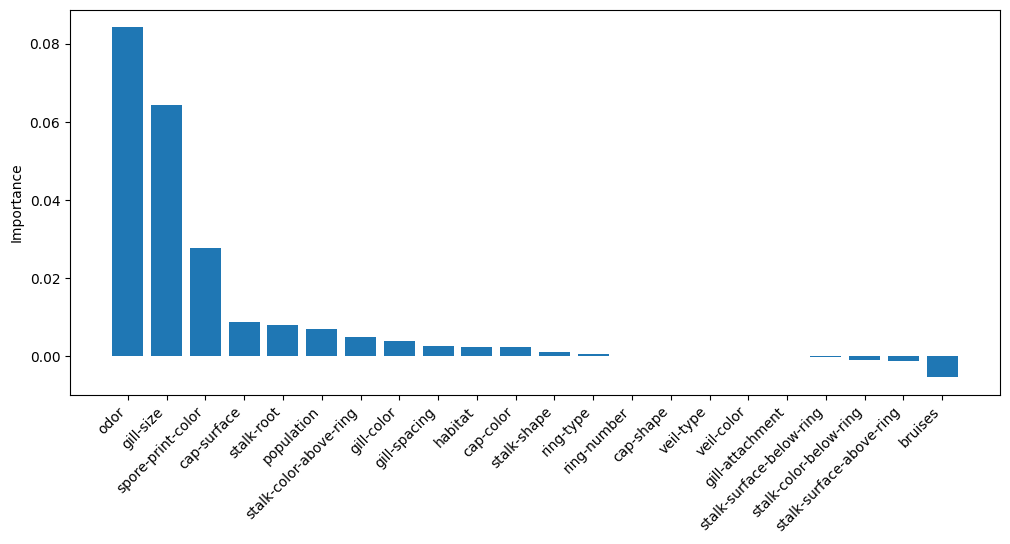

In [12]:
# Plot summed importances
plt.figure(figsize=(12, 5))
plt.bar(x = summed_importances['feature'], height = summed_importances['summed_importance'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')

The significance of feature importances lies in their ability to illuminate the variables that wield considerable influence over the model's predictions. In this specific instance, the analysis revealed that "odor," "gill-size," and "spore-print-color" stand out as pivotal and distinctive features that strongly impact the model's decision-making process. Features exhibiting higher permutation importances are indicative of their heightened relevance in steering the overall performance of the model.

In the given context, the toxicity of mushrooms appears to be closely associated with the inherent characteristics of the species itself. These characteristics, influenced by factors such as the color of spores and odor, play a crucial role in determining the model's predictions.

On a related note, the presence of negative importances in the feature analysis suggests a potential negative correlation between those specific features and the target variable. This could signify either a lesser contribution to predictive accuracy or an inversely proportional relationship with the target variable.

It's important to acknowledge that these insights are drawn from the dataset and analysis at hand. For a more comprehensive understanding, consulting expert sources is recommended. In a pertinent article¹, the authors underscore the significance of spore color and microscopic morphology for definitive mushroom identification.

[1] Beuhler, M.C. (2017). Overview of Mushroom Poisoning. In: Brent, J., et al. Critical Care Toxicology. Springer, Cham. https://doi.org/10.1007/978-3-319-17900-1_120

## Moving on to PDP Analysis
To begin the PDP analysis, the initial step involves computing the partial dependence values for a variable at both 0 and 1. Upon inspecting the data, it becomes apparent that the variable "veil-type" only takes on the value 'p' (partial). Consequently, partial dependence cannot be calculated for this variable, necessitating its exclusion from the analysis.

In [13]:
X_encoded.filter(regex='veil', axis=1)

,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y
0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
8119,1.0,0.0,1.0,0.0,0.0
8120,1.0,1.0,0.0,0.0,0.0
8121,1.0,0.0,1.0,0.0,0.0
8122,1.0,0.0,0.0,1.0,0.0


In [14]:
X=X.drop('veil-type',axis=1)

The strategy for plotting categorical variables that have undergone one-hot encoding involves identifying the common names for each encoded variable and grouping them in a graph to display the partial analysis for each of these variables.

KeyboardInterrupt: 

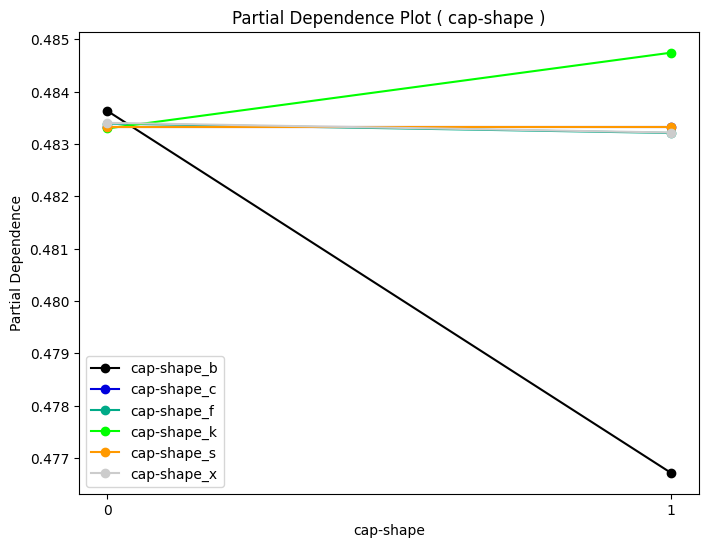

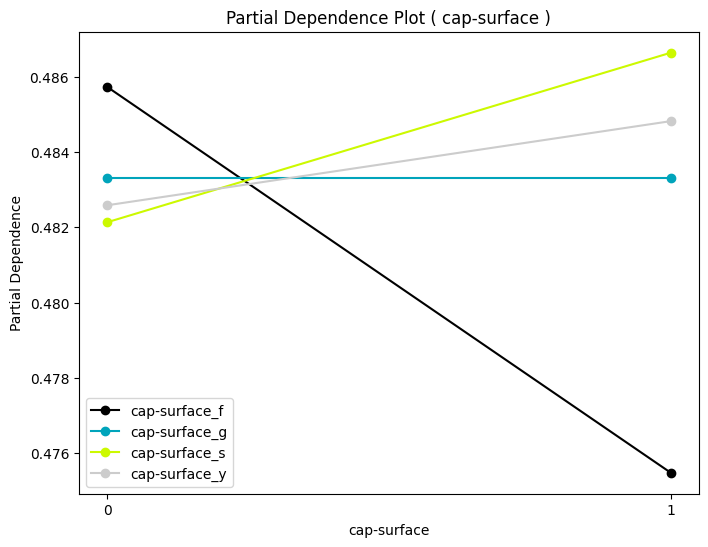

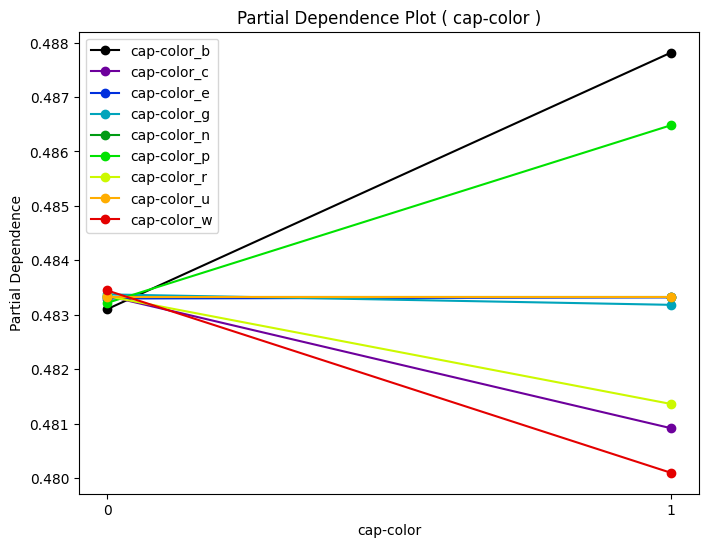

In [15]:
dif_pdp_dict = {'feature': [], 'pdp_e': [], 'pdp_p': [],'diff':[], 'abs_diff': []}

for name in X.columns.values:
    common_feature = X_encoded.filter(regex=name, axis=1)
    fig = plt.figure(figsize=(8,6))
    
    # Create a color map
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(common_feature.columns)))
    
    for i in range(len(common_feature.columns.values)):
        feat_name = common_feature.columns.values[i]
        pd = partial_dependence(model, features=feat_name, X=X_encoded, percentiles=(0, 1),grid_resolution=2)
        pdp_e = pd['average'][0][0]
        pdp_p = pd['average'][0][1]
        diff = pdp_p-pdp_e
        abs_diff = abs(diff)
        
        dif_pdp_dict['feature'].append(feat_name)
        dif_pdp_dict['pdp_e'].append(pdp_e)
        dif_pdp_dict['pdp_p'].append(pdp_p)
        dif_pdp_dict['diff'].append(diff)
        dif_pdp_dict['abs_diff'].append(abs_diff)
        
        plt.plot([0,1], [pdp_e,pdp_p], marker='o', label=feat_name, color=colors[i])
        plt.legend(loc = 'best')
        plt.xlabel(name)
        plt.ylabel('Partial Dependence')
        plt.title('Partial Dependence Plot ( ' + name + ' )')
        plt.xticks([0,1])
    plt.savefig('images/'+name+'.png')


Due to the numerous variables resulting from one-hot encoding, interpreting the graphs might be perplexing. The use of a dataframe facilitates a clearer understanding of the features that significantly influenced the model's decisions. 

In [16]:
import pandas as pd
dif_pdp_df = pd.DataFrame(dif_pdp_dict).sort_values(by='abs_diff', ascending=False)
display(dif_pdp_df)


,feature,pdp_e,pdp_p,diff,abs_diff
6,cap-surface_f,0.485733,0.475477,-0.010256,0.010256
0,cap-shape_b,0.483634,0.476721,-0.006913,0.006913
10,cap-color_b,0.483102,0.487813,0.004711,0.004711
8,cap-surface_s,0.482133,0.486640,0.004506,0.004506
18,cap-color_w,0.483446,0.480097,-0.003349,0.003349
15,cap-color_p,0.483216,0.486479,0.003262,0.003262
11,cap-color_c,0.483347,0.480916,-0.002431,0.002431
9,cap-surface_y,0.482585,0.484821,0.002236,0.002236
16,cap-color_r,0.483340,0.481361,-0.001978,0.001978
3,cap-shape_k,0.483296,0.484742,0.001446,0.001446


In this instance, the odor features and gill size exhibited the four most substantial absolute differences, aligning closely with the outcomes of the importance analysis. This alignment underscores the crucial influence of these variables in shaping the model's predictions.

When the absence of odor (odor_n) is present in the mushroom, the likelihood of it being poisonous decreases. Conversely, the presence of a foul odor (odor_f) increases the chances of the mushroom being poisonous. Additionally, other factors contributing to potential toxicity include a narrow gill size (gill-size_n) and a buff gill color (gill-color_b), while a broad gill size (gill-size_b) does not seem to be indicative of poison.

On the other hand, various other features, such as musty odor, conical cap shape, and yellow veil color, among many others present in the table, did not yield significant conclusions for the model's decision-making.

## Moving on to SHAP values Analysis

Define the explainer. In this case because we are using the Random Forest Model we are going to use the TreeExplainer object.


In [17]:
explainer = shap.TreeExplainer(model, X_encoded)

This analysis is made to explain a single row.
Let's select a few rows for SHAP analysis.

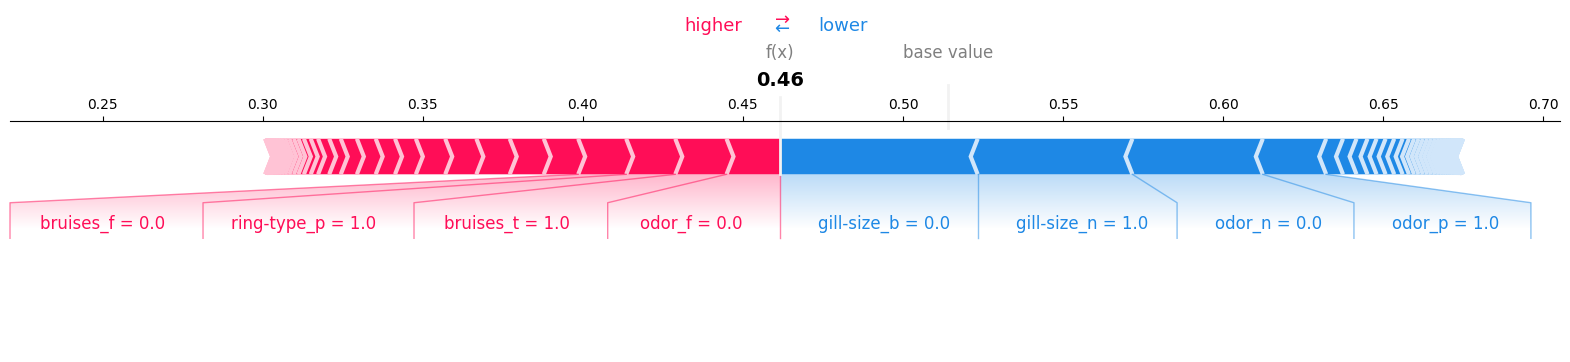

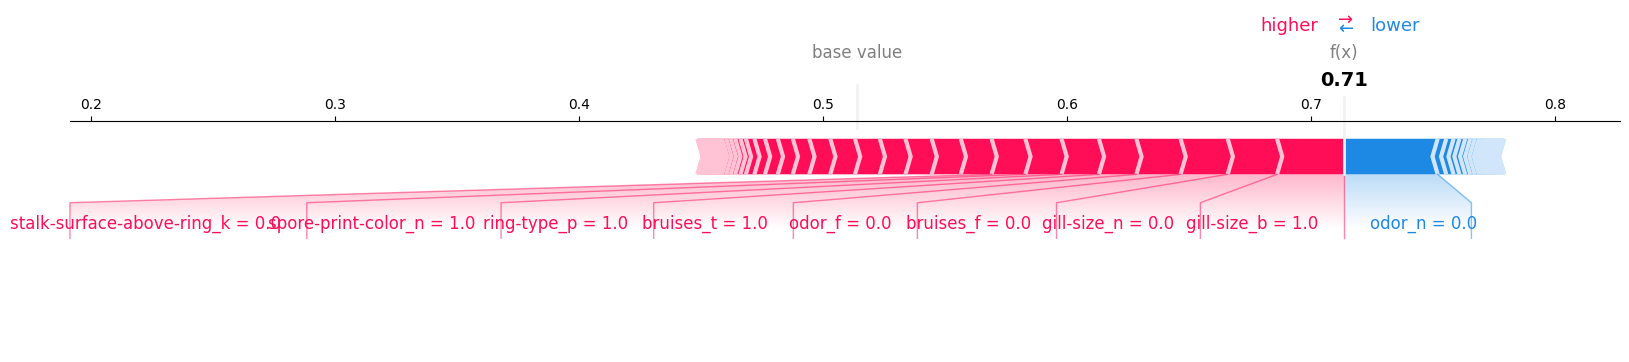

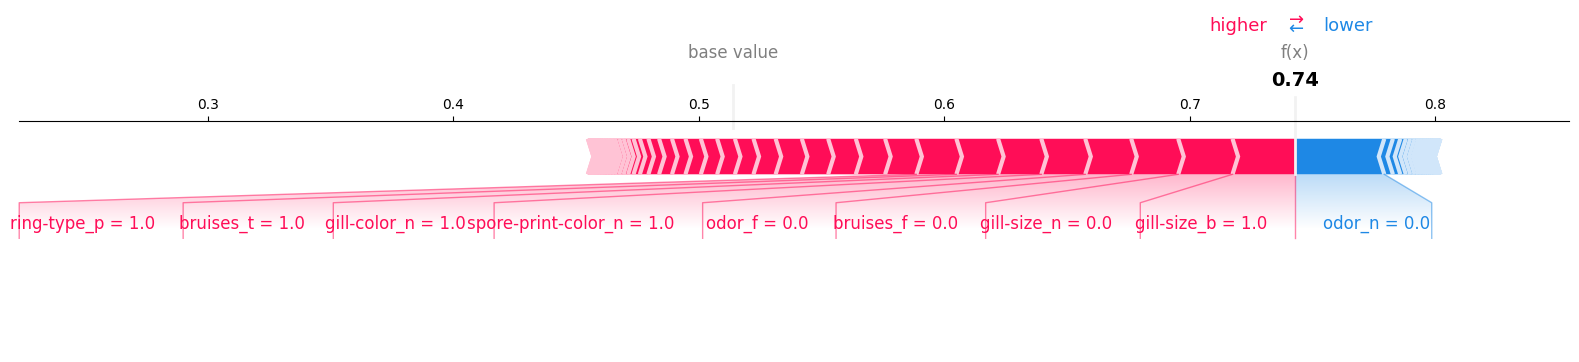

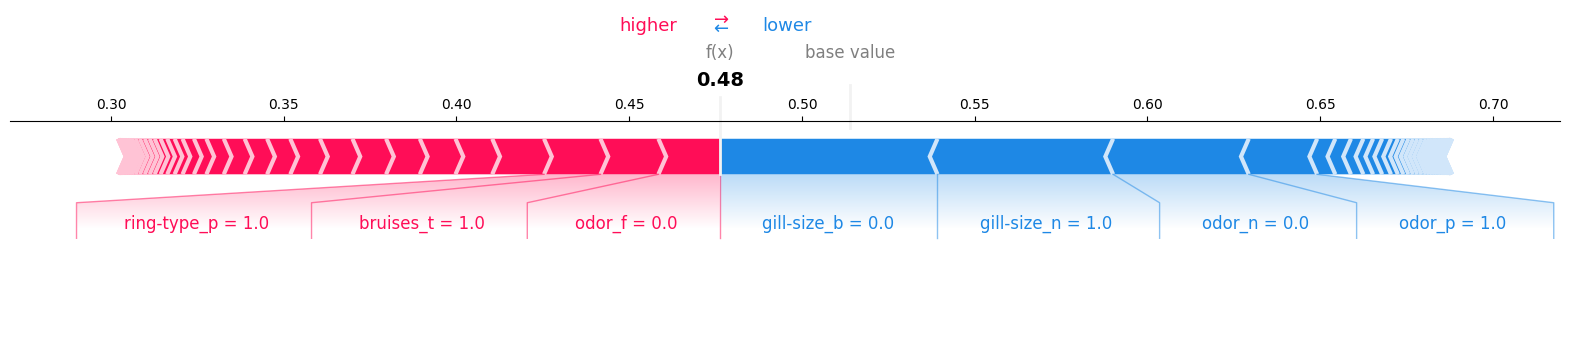

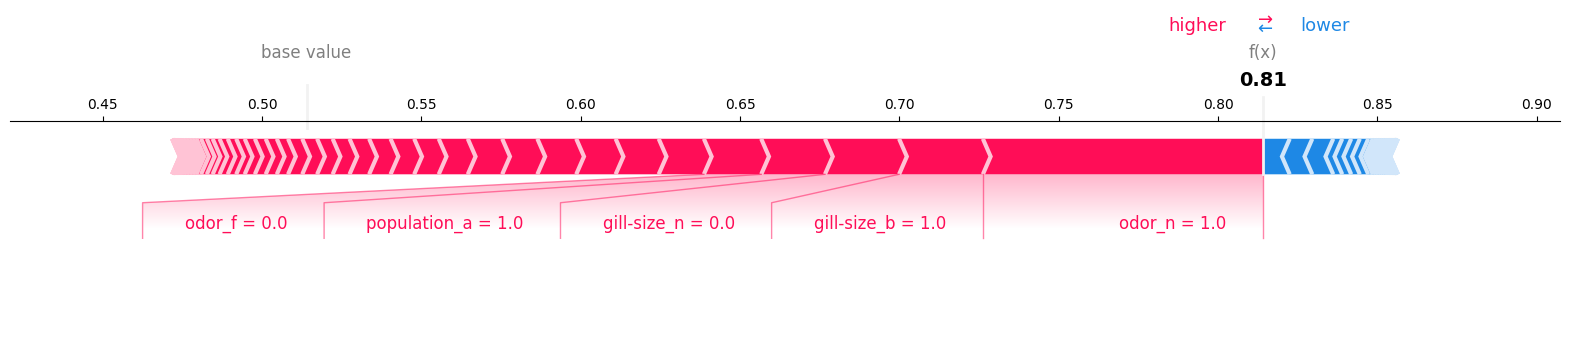

In [18]:
for i in range(0,5):
# get shap values for first observation
    data_for_prediction = X_encoded.iloc[[i]] # use 1 row of data here.
    shap_values = explainer.shap_values(data_for_prediction)
    force_plot = shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, matplotlib=True)

Even though the initial two rows share the commonality of odor_n = 0, the distinct values of gill-size_b and stalk-root_c in these rows play a pivotal role in drastically altering the model's decision. Moreover, a clear shift in the model's perception is observable in the analysis of the fifth row where odor_n = 1. Consequently, it becomes apparent that odor_n stands out as the most influential variable for predicting the output in this dataset.

We can see THE SHAP values for all the features and rows

In [19]:
shap_values = explainer.shap_values(X_encoded)
#shap.summary_plot(shap_values[1], X_encoded)

 97%|=================== | 15817/16248 [00:31<00:00]       

Observe the notable distinction between high and low values of the variables, highlighting the model's exceptional proficiency in determining the class output based on these values. Once more, the variables odor_n and odor_f, as well as gill-size_b, gill-size_n, and gill-color_b, emerge as decisive factors influencing the output. This is evident from the substantial difference in SHAP values between low and high values. Importantly, these are precisely the same variables that exhibited the maximum absolute difference in the partial dependence analysis. The consistency across analyses confirms the pivotal role of odor and gill-size in shaping the model's decisions, as these variables also ranked highest in terms of importances.

Just as we aggregated and combined importances and partial dependences, we will employ a parallel methodology to handle SHAP values.

In [20]:
summed_shaps_df = pd.DataFrame(columns=X_encoded.columns.values, data=shap_values[0])
summed_shaps_df
#shap_values[0][linha][coluna no X_encoded] 

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,-0.000491,0.0,-0.000031,-0.000241,0.0,0.000024,-0.003429,0.0,-0.002831,0.000304,...,-0.002623,0.010419,-0.001415,-0.000245,0.000602,-0.000006,0.0,-0.000071,-0.002695,-0.000224
1,-0.000470,0.0,-0.000031,-0.000025,0.0,0.000037,-0.002346,0.0,-0.003013,0.000304,...,0.000317,0.008605,0.000133,-0.000606,-0.002057,0.000000,0.0,0.000822,0.000272,-0.000221
2,0.007239,0.0,-0.000031,-0.000025,0.0,-0.000046,-0.002244,0.0,-0.003013,0.000304,...,0.000317,0.007570,0.000133,-0.000606,0.000602,0.000000,0.0,0.001287,0.000169,-0.000221
3,-0.000491,0.0,-0.000031,-0.000241,0.0,0.000024,-0.003586,0.0,0.001437,-0.000729,...,-0.002623,0.009401,-0.001472,-0.000245,0.000602,-0.000006,0.0,-0.000031,-0.002564,-0.000224
4,-0.000198,0.0,-0.000222,0.000308,0.0,0.000137,-0.002648,0.0,-0.002813,0.000975,...,0.000257,0.013508,0.001014,-0.001403,0.003191,-0.000010,0.0,0.003395,0.000238,-0.000181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,-0.000217,0.0,-0.000031,0.000030,0.0,-0.000152,-0.002402,0.0,-0.001653,0.000975,...,-0.000013,0.010172,0.001193,-0.000726,-0.001437,0.000130,0.0,0.002479,0.000120,-0.000188
8120,-0.000217,0.0,-0.000031,-0.000025,0.0,0.000137,-0.002799,0.0,-0.001653,0.000975,...,-0.000013,-0.010378,0.001193,-0.000698,-0.001427,0.000130,0.0,0.002868,0.000120,-0.000138
8121,-0.000217,0.0,0.000069,-0.000025,0.0,-0.000152,-0.001510,0.0,-0.001653,0.000975,...,-0.000013,0.009154,0.001193,-0.000726,-0.001437,0.000130,0.0,0.002995,0.000106,-0.000188
8122,-0.000817,0.0,-0.000031,-0.001510,0.0,-0.000030,-0.002742,0.0,0.000888,-0.001995,...,-0.000090,-0.015388,-0.001347,-0.000466,-0.001956,0.000111,0.0,0.001576,0.000127,-0.000278


CALCULANDO SHAP VALUE PARA UMA LINHA SOMENTE

In [280]:
summed_shaps = pd.DataFrame(columns=['feature','summed_shaps','abs_summed_shaps'])
idx = 812
for feat_name in X.columns.values:
    common_feature = X_encoded.filter(regex=feat_name, axis=1)
    encoded_variables = common_feature.columns.values # get the encoded variables
    select_columns = summed_shaps_df[encoded_variables]
    summed_features = select_columns.iloc[idx].sum()
    abs_summed_shaps = abs(summed_features)
    warnings.filterwarnings("ignore")
    summed_shaps = summed_shaps.append({'feature': feat_name, 'summed_shaps': summed_features, 'abs_summed_shaps': abs_summed_shaps}, ignore_index=True)
    summed_shaps = summed_shaps.sort_values(by='abs_summed_shaps', ascending=False, ignore_index=True) # sort dataframe by summed shaps
summed_shaps

,feature,summed_shaps,abs_summed_shaps
0,gill-size,-0.109986,0.109986
1,odor,-0.040869,0.040869
2,bruises,0.036142,0.036142
3,ring-type,0.024941,0.024941
4,spore-print-color,0.015160,0.015160
5,stalk-surface-above-ring,0.014359,0.014359
6,stalk-surface-below-ring,0.013763,0.013763
7,population,-0.013082,0.013082
8,gill-color,0.008113,0.008113
9,stalk-color-below-ring,0.006399,0.006399


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,s,w,w,w,o,p,k,s,u


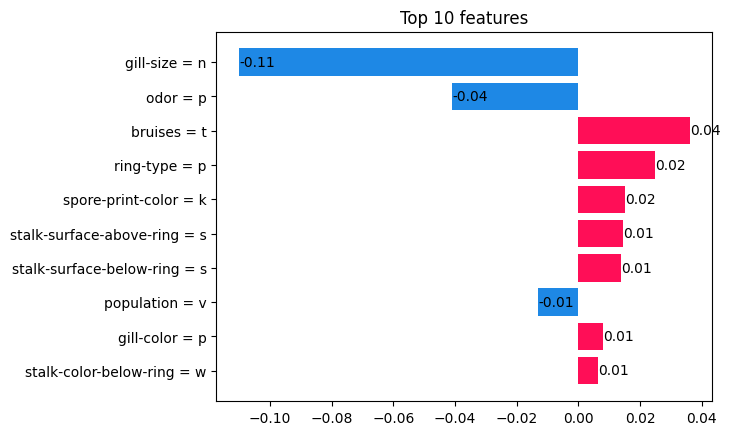

In [281]:
# Defina as cores das barras
colors = [(1, 0.0549, 0.3412) if val > 0 else (0.1176, 0.5333, 0.8980) for val in summed_shaps['summed_shaps']]

topX_features = 10
summed_shaps = summed_shaps.reset_index(drop=True).head(topX_features)
display(X.iloc[[0]])

plt.barh(y = summed_shaps['feature'] + ' = ' , width = summed_shaps['summed_shaps'], color = colors)
# Adicione rótulos aos ticks do eixo y
for i, (feature, shap_value) in enumerate(zip(summed_shaps['feature'], summed_shaps['summed_shaps'])):
    plt.text(shap_value, i, f'{shap_value:.2f}', ha='left', va='center')

plt.yticks(range(topX_features), summed_shaps['feature'].head(topX_features) + ' = ' + X[summed_shaps['feature']].iloc[idx].to_numpy())
plt.gca().invert_yaxis()
plt.title('Top 10 features')
plt.show()

fAZER A MESMA COISA COM A BASE DE DADOS TOTAL E TIRAR A MÉDIA

In [297]:
summed_shaps = pd.DataFrame(columns=['feature','summed_shaps','abs_summed_shaps'])
for idx in range(len(X)):
    for feat_name in X.columns.values:
        common_feature = X_encoded.filter(regex=feat_name, axis=1)
        encoded_variables = common_feature.columns.values # get the encoded variables
        select_columns = summed_shaps_df[encoded_variables]
        summed_features = select_columns.iloc[idx].sum()
        abs_summed_shaps = abs(summed_features)
        warnings.filterwarnings("ignore")
        summed_shaps = summed_shaps.append({'feature': feat_name, 'summed_shaps': summed_features, 'abs_summed_shaps': abs_summed_shaps}, ignore_index=True)
summed_shaps

,feature,summed_shaps,abs_summed_shaps
0,cap-shape,-0.000739,0.000739
1,cap-surface,-0.005956,0.005956
2,cap-color,-0.000292,0.000292
3,bruises,0.030999,0.030999
4,odor,-0.042159,0.042159
...,...,...,...
170599,ring-number,-0.000533,0.000533
170600,ring-type,0.026870,0.026870
170601,spore-print-color,0.007852,0.007852
170602,population,0.010456,0.010456


agora agrupar por feature e tirar a média

In [348]:
summed_shaps_mean = summed_shaps.groupby('feature').mean()
summed_shaps_mean = summed_shaps_mean.sort_values(by='abs_summed_shaps', ascending=False) # sort dataframe by summed shaps
topX_features = 10
summed_shaps_mean = summed_shaps_mean.head(topX_features)
summed_shaps_mean

,summed_shaps,abs_summed_shaps
feature,,
odor,0.008802,0.081598
gill-size,-0.002182,0.063073
bruises,-0.003089,0.029835
stalk-surface-above-ring,-0.000422,0.025305
stalk-surface-below-ring,0.000016,0.023604
ring-type,-0.000346,0.022486
spore-print-color,0.000640,0.022362
gill-color,-0.002516,0.021855
population,-0.000758,0.012497


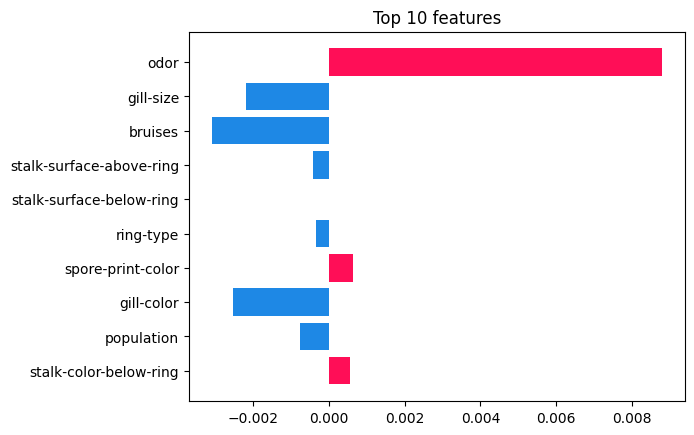

In [349]:
colors = [(1, 0.0549, 0.3412) if val > 0 else (0.1176, 0.5333, 0.8980) for val in summed_shaps_mean['summed_shaps']]
plt.barh(y=summed_shaps_mean.index, width = summed_shaps_mean['summed_shaps'], color = colors)

plt.yticks(range(topX_features), summed_shaps_mean.index)
plt.gca().invert_yaxis()
plt.title('Top 10 features')
plt.show()